## hparams.py

In [1]:
from easydict import EasyDict

def create_hparams(hparams_string=None, verbose=False):
    """Create model hyperparameters. Parse nondefault from given string."""

    hparams = EasyDict(
        ################################
        # Experiment Parameters        #
        ################################
        epochs=500,
        iters_per_checkpoint=1000,
        seed=1234,
        dynamic_loss_scaling=True,
        fp16_run=False,
        distributed_run=False,
        dist_backend="nccl",
        dist_url="tcp://localhost:54321",
        cudnn_enabled=True,
        cudnn_benchmark=False,
        ignore_layers=['embedding.weight', 'latent_encoder'],

        ################################
        # Data Parameters             #
        ################################
        load_mel_from_disk=False,
        training_files='filelists/lj+kss+sm_audio_text_train_filelist.txt',
        validation_files='filelists/lj+kss+sm-speaker_audio_text_val_filelist.txt',
        text_cleaners=['english_cleaners'],

        ################################
        # Audio Parameters             #
        ################################
        max_wav_value=32768.0,
        sampling_rate=22050,
        filter_length=1024,
        hop_length=256,
        win_length=1024,
        n_mel_channels=80,
        mel_fmin=0.0,
        mel_fmax=8000.0,

        ################################
        # Model Parameters             #
        ################################
        n_symbols=256,
        symbols_embedding_dim=512,
        n_speakers=10,
        speaker_embedding_dim=128,

        # Encoder parameters
        encoder_kernel_size=5,
        encoder_n_convolutions=3,
        encoder_embedding_dim=512,
        
        # Decoder parameters
        n_frames_per_step=1,  # currently only 1 is supported
        decoder_rnn_dim=1024,
        prenet_dim=256,
        max_decoder_steps=1000,
        gate_threshold=0.5,
        p_attention_dropout=0.1,
        p_decoder_dropout=0.1,

        # Attention parameters
        attention_rnn_dim=1024,
        attention_dim=128,

        # Location Layer parameters
        attention_location_n_filters=32,
        attention_location_kernel_size=31,

        # Mel-post processing network parameters
        postnet_embedding_dim=512,
        postnet_kernel_size=5,
        postnet_n_convolutions=5,

        ################################
        # Optimization Hyperparameters #
        ################################
        use_saved_learning_rate=False,
        learning_rate=1e-3,
        weight_decay=1e-6,
        grad_clip_thresh=1.0,
        batch_size=24,
        mask_padding=True  # set model's padded outputs to padded values
    )

#     if hparams_string:
#         tf.logging.info('Parsing command line hparams: %s', hparams_string)
#         hparams.parse(hparams_string)

#     if verbose:
#         tf.logging.info('Final parsed hparams: %s', hparams.values())

    return hparams


## utils.py

In [2]:
import numpy as np
from scipy.io.wavfile import read
import torch
import librosa

def text_to_utf8(text):
    utf = []
    for u in text.encode('utf-8'):
        utf.append(u)
        
    return np.array(utf).astype(int)

def get_mask_from_lengths(lengths):
    max_len = torch.max(lengths).item()
    ids = torch.arange(0, max_len, out=torch.cuda.LongTensor(max_len))
    mask = (ids < lengths.unsqueeze(1)).bool()
    return mask

def load_wav_to_torch(full_path):
    data, sampling_rate = librosa.core.load(full_path, sr=22050, mono=True)
    data /= max(abs(data))
    data = librosa.effects.trim(data, top_db=40, frame_length=1024, hop_length=256)[0]
    return torch.FloatTensor(data.astype(np.float32)), sampling_rate


def load_filepaths_and_text(filename, split="|"):
    with open(filename, encoding='utf-8') as f:
        filepaths_and_text = [line.strip().split(split) for line in f]
    return filepaths_and_text


def to_gpu(x):
    x = x.contiguous()

    if torch.cuda.is_available():
        x = x.cuda(non_blocking=True)
    return torch.autograd.Variable(x)

def make_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        Tensor: Mask tensor containing indices of padded part.
                dtype=torch.uint8 in PyTorch 1.2-
                dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[0, 0, 0, 0 ,0],
                 [0, 0, 0, 1, 1],
                 [0, 0, 1, 1, 1]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0],
                 [0, 0, 0, 0]],
                [[0, 0, 0, 1],
                 [0, 0, 0, 1]],
                [[0, 0, 1, 1],
                 [0, 0, 1, 1]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_pad_mask(lengths, xs)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_pad_mask(lengths, xs, 1)
        tensor([[[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]],
                [[0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1]]], dtype=torch.uint8)
        >>> make_pad_mask(lengths, xs, 2)
        tensor([[[0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1],
                 [0, 0, 0, 0, 0, 1]],
                [[0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1],
                 [0, 0, 0, 1, 1, 1]],
                [[0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1],
                 [0, 0, 1, 1, 1, 1]]], dtype=torch.uint8)

    """
    if length_dim == 0:
        raise ValueError('length_dim cannot be 0: {}'.format(length_dim))

    if not isinstance(lengths, list):
        lengths = lengths.tolist()
    bs = int(len(lengths))
    if xs is None:
        maxlen = int(max(lengths))
    else:
        maxlen = xs.size(length_dim)

    seq_range = torch.arange(0, maxlen, dtype=torch.int64)
    seq_range_expand = seq_range.unsqueeze(0).expand(bs, maxlen)
    seq_length_expand = seq_range_expand.new(lengths).unsqueeze(-1)
    mask = seq_range_expand >= seq_length_expand

    if xs is not None:
        assert xs.size(0) == bs, (xs.size(0), bs)

        if length_dim < 0:
            length_dim = xs.dim() + length_dim
        # ind = (:, None, ..., None, :, , None, ..., None)
        ind = tuple(slice(None) if i in (0, length_dim) else None
                    for i in range(xs.dim()))
        mask = mask[ind].expand_as(xs).to(xs.device)
    return mask


def make_non_pad_mask(lengths, xs=None, length_dim=-1):
    """Make mask tensor containing indices of non-padded part.

    Args:
        lengths (LongTensor or List): Batch of lengths (B,).
        xs (Tensor, optional): The reference tensor. If set, masks will be the same shape as this tensor.
        length_dim (int, optional): Dimension indicator of the above tensor. See the example.

    Returns:
        ByteTensor: mask tensor containing indices of padded part.
                    dtype=torch.uint8 in PyTorch 1.2-
                    dtype=torch.bool in PyTorch 1.2+ (including 1.2)

    Examples:
        With only lengths.

        >>> lengths = [5, 3, 2]
        >>> make_non_pad_mask(lengths)
        masks = [[1, 1, 1, 1 ,1],
                 [1, 1, 1, 0, 0],
                 [1, 1, 0, 0, 0]]

        With the reference tensor.

        >>> xs = torch.zeros((3, 2, 4))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1],
                 [1, 1, 1, 1]],
                [[1, 1, 1, 0],
                 [1, 1, 1, 0]],
                [[1, 1, 0, 0],
                 [1, 1, 0, 0]]], dtype=torch.uint8)
        >>> xs = torch.zeros((3, 2, 6))
        >>> make_non_pad_mask(lengths, xs)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

        With the reference tensor and dimension indicator.

        >>> xs = torch.zeros((3, 6, 6))
        >>> make_non_pad_mask(lengths, xs, 1)
        tensor([[[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]],
                [[1, 1, 1, 1, 1, 1],
                 [1, 1, 1, 1, 1, 1],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0],
                 [0, 0, 0, 0, 0, 0]]], dtype=torch.uint8)
        >>> make_non_pad_mask(lengths, xs, 2)
        tensor([[[1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0],
                 [1, 1, 1, 1, 1, 0]],
                [[1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0],
                 [1, 1, 1, 0, 0, 0]],
                [[1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0],
                 [1, 1, 0, 0, 0, 0]]], dtype=torch.uint8)

    """
    return ~make_pad_mask(lengths, xs, length_dim)


## layers.py

In [3]:
import torch
from librosa.filters import mel as librosa_mel_fn
from audio_processing import dynamic_range_compression
from audio_processing import dynamic_range_decompression
from stft import STFT

class LinearNorm(torch.nn.Module):
    def __init__(self, in_dim, out_dim, bias=True, w_init_gain='linear'):
        super(LinearNorm, self).__init__()
        self.linear_layer = torch.nn.Linear(in_dim, out_dim, bias=bias)

        torch.nn.init.xavier_uniform_(
            self.linear_layer.weight,
            gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, x):
        return self.linear_layer(x)


class ConvNorm(torch.nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=1, stride=1,
                 padding=None, dilation=1, bias=True, w_init_gain='linear'):
        super(ConvNorm, self).__init__()
        if padding is None:
            assert(kernel_size % 2 == 1)
            padding = int(dilation * (kernel_size - 1) / 2)

        self.conv = torch.nn.Conv1d(in_channels, out_channels,
                                    kernel_size=kernel_size, stride=stride,
                                    padding=padding, dilation=dilation,
                                    bias=bias)

        torch.nn.init.xavier_uniform_(
            self.conv.weight, gain=torch.nn.init.calculate_gain(w_init_gain))

    def forward(self, signal):
        conv_signal = self.conv(signal)
        return conv_signal


class TacotronSTFT(torch.nn.Module):
    def __init__(self, filter_length=1024, hop_length=256, win_length=1024,
                 n_mel_channels=80, sampling_rate=22050, mel_fmin=0.0,
                 mel_fmax=8000.0):
        super(TacotronSTFT, self).__init__()
        self.n_mel_channels = n_mel_channels
        self.sampling_rate = sampling_rate
        self.stft_fn = STFT(filter_length, hop_length, win_length)
        mel_basis = librosa_mel_fn(
            sampling_rate, filter_length, n_mel_channels, mel_fmin, mel_fmax)
        mel_basis = torch.from_numpy(mel_basis).float()
        self.register_buffer('mel_basis', mel_basis)

    def spectral_normalize(self, magnitudes):
        output = dynamic_range_compression(magnitudes)
        return output

    def spectral_de_normalize(self, magnitudes):
        output = dynamic_range_decompression(magnitudes)
        return output

    def mel_spectrogram(self, y):
        """Computes mel-spectrograms from a batch of waves
        PARAMS
        ------
        y: Variable(torch.FloatTensor) with shape (B, T) in range [-1, 1]

        RETURNS
        -------
        mel_output: torch.FloatTensor of shape (B, n_mel_channels, T)
        """
        assert(torch.min(y.data) >= -1)
        assert(torch.max(y.data) <= 1)

        magnitudes, phases = self.stft_fn.transform(y)
        magnitudes = magnitudes.data
        mel_output = torch.matmul(self.mel_basis, magnitudes)
        mel_output = self.spectral_normalize(mel_output)
        return mel_output


## data_utils.py

In [4]:
import random
import numpy as np
import torch
import torch.utils.data
import os

class TextMelLoader(torch.utils.data.Dataset):
    """
        1) loads audio,text pairs
        2) normalizes text and converts them to sequences of one-hot vectors
        3) computes mel-spectrograms from audio files.
    """
    def __init__(self, audiopaths_and_text, hparams):
        self.audiopaths_and_text = load_filepaths_and_text(audiopaths_and_text)
        self.text_cleaners = hparams.text_cleaners
        self.max_wav_value = hparams.max_wav_value
        self.sampling_rate = hparams.sampling_rate
        self.load_mel_from_disk = hparams.load_mel_from_disk
        self.stft = TacotronSTFT(
            hparams.filter_length, hparams.hop_length, hparams.win_length,
            hparams.n_mel_channels, hparams.sampling_rate, hparams.mel_fmin,
            hparams.mel_fmax)
        random.seed(1234)
        random.shuffle(self.audiopaths_and_text)
        
    def get_mel_text_pair(self, audiopath_and_text):
        # separate filename and text
        audiopath, text, speaker = audiopath_and_text[0], audiopath_and_text[1], audiopath_and_text[2]
        text = self.get_text(text)
        mel = self.get_mel(audiopath)
        
        return (text, mel, speaker)

    def get_mel(self, filename):
        if not self.load_mel_from_disk:
            audio, sampling_rate = load_wav_to_torch(filename)
            if sampling_rate != self.stft.sampling_rate:
                raise ValueError("{} {} SR doesn't match target {} SR".format(
                    sampling_rate, self.stft.sampling_rate))
            #audio_norm = audio / self.max_wav_value
            audio_norm = audio
            audio_norm = audio_norm.unsqueeze(0)
            audio_norm = torch.autograd.Variable(audio_norm, requires_grad=False)
            melspec = self.stft.mel_spectrogram(audio_norm)
            melspec = torch.squeeze(melspec, 0)
        else:
            melspec = torch.from_numpy(np.load(filename))
            assert melspec.size(0) == self.stft.n_mel_channels, (
                'Mel dimension mismatch: given {}, expected {}'.format(
                    melspec.size(0), self.stft.n_mel_channels))
        
        melspec = melspec
        
        return melspec

    def get_text(self, text):
        text_norm = torch.IntTensor(text_to_utf8(text))
        #text_norm = torch.IntTensor(text_to_sequence(text, self.text_cleaners))
        return text_norm

    def __getitem__(self, index):
        return self.get_mel_text_pair(self.audiopaths_and_text[index])

    def __len__(self):
        return len(self.audiopaths_and_text)


class TextMelCollate():
    """ Zero-pads model inputs and targets based on number of frames per setep
    """
    def __init__(self, n_frames_per_step):
        self.n_frames_per_step = n_frames_per_step

    def __call__(self, batch):
        """Collate's training batch from normalized text and mel-spectrogram
        PARAMS
        ------
        batch: [text_normalized, mel_normalized, speaker]
        """
        # mel sort
        output_lengths, ids_sorted_decreasing = torch.sort(
            torch.LongTensor([x[1].size(1) for x in batch]),
            dim=0, descending=True)
        max_target_len = output_lengths[0]

        max_input_len = max([len(x[0]) for x in batch])
        text_padded = torch.LongTensor(len(batch), max_input_len)
        text_padded.zero_()
        input_lengths = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            text = batch[ids_sorted_decreasing[i]][0]
            text_padded[i, :text.size(0)] = text
            input_lengths[i] = text.size(0)

        speakers = torch.LongTensor(len(batch))
        for i in range(len(ids_sorted_decreasing)):
            speaker = batch[ids_sorted_decreasing[i]][2]
            speakers[i] = int(speaker)

        # Right zero-pad mel-spec
        num_mels = batch[0][1].size(0)
        if max_target_len % self.n_frames_per_step != 0:
            max_target_len += self.n_frames_per_step - max_target_len % self.n_frames_per_step
            assert max_target_len % self.n_frames_per_step == 0

        # include mel padded and gate padded
        mel_padded = torch.FloatTensor(len(batch), num_mels, max_target_len)
        mel_padded.zero_()
        gate_padded = torch.FloatTensor(len(batch), max_target_len)
        gate_padded.zero_()
        output_lengths = torch.LongTensor(len(batch))
        
        for i in range(len(ids_sorted_decreasing)):
            mel = batch[ids_sorted_decreasing[i]][1]
            mel_padded[i, :, :mel.size(1)] = mel
            gate_padded[i, mel.size(1)-1:] = 1
            output_lengths[i] = mel.size(1)
        
        outputs = {}
        outputs.update({"text_padded": text_padded})
        outputs.update({"input_lengths": input_lengths})
        outputs.update({"mel_padded": mel_padded})
        outputs.update({"gate_padded": gate_padded})
        outputs.update({"output_lengths": output_lengths})
        outputs.update({"speakers": speakers})
        
        return outputs

## loss_function.py

In [5]:
import torch
from torch import nn

class GuidedAttentionLoss(nn.Module):
    """Guided attention loss function module.

    This module calculates the guided attention loss described in `Efficiently Trainable Text-to-Speech System Based
    on Deep Convolutional Networks with Guided Attention`_, which forces the attention to be diagonal.

    .. _`Efficiently Trainable Text-to-Speech System Based on Deep Convolutional Networks with Guided Attention`:
        https://arxiv.org/abs/1710.08969

    """

    def __init__(self, sigma=0.4, alpha=1.0, reset_always=True):
        """Initialize guided attention loss module.

        Args:
            sigma (float, optional): Standard deviation to control how close attention to a diagonal.
            alpha (float, optional): Scaling coefficient (lambda).
            reset_always (bool, optional): Whether to always reset masks.

        """
        super(GuidedAttentionLoss, self).__init__()
        self.sigma = sigma
        self.alpha = alpha
        self.reset_always = reset_always
        self.guided_attn_masks = None
        self.masks = None

    def _reset_masks(self):
        self.guided_attn_masks = None
        self.masks = None

    def forward(self, att_ws, ilens, olens):
        """Calculate forward propagation.

        Args:
            att_ws (Tensor): Batch of attention weights (B, T_max_out, T_max_in).
            ilens (LongTensor): Batch of input lenghts (B,).
            olens (LongTensor): Batch of output lenghts (B,).

        Returns:
            Tensor: Guided attention loss value.

        """
        if self.guided_attn_masks is None:
            self.guided_attn_masks = self._make_guided_attention_masks(ilens, olens).to(att_ws.device)
        if self.masks is None:
            self.masks = self._make_masks(ilens, olens).to(att_ws.device)
        losses = self.guided_attn_masks * att_ws
        loss = torch.mean(losses.masked_select(self.masks))
        if self.reset_always:
            self._reset_masks()
        return self.alpha * loss

    def _make_guided_attention_masks(self, ilens, olens):
        n_batches = len(ilens)
        max_ilen = max(ilens)
        max_olen = max(olens)
        guided_attn_masks = torch.zeros((n_batches, max_olen, max_ilen))
        for idx, (ilen, olen) in enumerate(zip(ilens, olens)):
            guided_attn_masks[idx, :olen, :ilen] = self._make_guided_attention_mask(ilen, olen, self.sigma)
        return guided_attn_masks

    @staticmethod
    def _make_guided_attention_mask(ilen, olen, sigma):
        """Make guided attention mask.

        Examples:
            >>> guided_attn_mask =_make_guided_attention(5, 5, 0.4)
            >>> guided_attn_mask.shape
            torch.Size([5, 5])
            >>> guided_attn_mask
            tensor([[0.0000, 0.1175, 0.3935, 0.6753, 0.8647],
                    [0.1175, 0.0000, 0.1175, 0.3935, 0.6753],
                    [0.3935, 0.1175, 0.0000, 0.1175, 0.3935],
                    [0.6753, 0.3935, 0.1175, 0.0000, 0.1175],
                    [0.8647, 0.6753, 0.3935, 0.1175, 0.0000]])
            >>> guided_attn_mask =_make_guided_attention(3, 6, 0.4)
            >>> guided_attn_mask.shape
            torch.Size([6, 3])
            >>> guided_attn_mask
            tensor([[0.0000, 0.2934, 0.7506],
                    [0.0831, 0.0831, 0.5422],
                    [0.2934, 0.0000, 0.2934],
                    [0.5422, 0.0831, 0.0831],
                    [0.7506, 0.2934, 0.0000],
                    [0.8858, 0.5422, 0.0831]])

        """
        grid_x, grid_y = torch.meshgrid(torch.arange(olen), torch.arange(ilen))
        grid_x, grid_y = grid_x.float(), grid_y.float()
        return 1.0 - torch.exp(-(grid_y / ilen - grid_x / olen) ** 2 / (2 * (sigma ** 2)))

    @staticmethod
    def _make_masks(ilens, olens):
        """Make masks indicating non-padded part.

        Args:
            ilens (LongTensor or List): Batch of lengths (B,).
            olens (LongTensor or List): Batch of lengths (B,).

        Returns:
            Tensor: Mask tensor indicating non-padded part.
                    dtype=torch.uint8 in PyTorch 1.2-
                    dtype=torch.bool in PyTorch 1.2+ (including 1.2)

        Examples:
            >>> ilens, olens = [5, 2], [8, 5]
            >>> _make_mask(ilens, olens)
            tensor([[[1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1],
                     [1, 1, 1, 1, 1]],
                    [[1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [1, 1, 0, 0, 0],
                     [0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0],
                     [0, 0, 0, 0, 0]]], dtype=torch.uint8)

        """
        in_masks = make_non_pad_mask(ilens)  # (B, T_in)
        out_masks = make_non_pad_mask(olens)  # (B, T_out)
        return out_masks.unsqueeze(-1) & in_masks.unsqueeze(-2)  # (B, T_out, T_in)


class Tacotron2Loss(nn.Module):
    def __init__(self):
        super(Tacotron2Loss, self).__init__()
        self.attn_loss = GuidedAttentionLoss(sigma=0.4, alpha=1.0)
        
    def _masked_loss(self, output, target, mask, criterion='L2'):
        if criterion == 'L2':
            loss = torch.mean((output - target) ** 2, dim=1) * mask
            loss = torch.mean(loss)
            
        return loss
    
    def forward(self, batch, outputs):
        
        text_padded = batch["text_padded"]
        input_lengths = batch["input_lengths"]
        mel_padded = batch["mel_padded"]
        max_len = batch["max_len"]
        output_lengths = batch["output_lengths"]
        mel_target = batch["mel_padded"]
        gate_target = batch["gate_padded"]
        speakers = batch["speakers"]

        mel_target.requires_grad = False
        gate_target.requires_grad = False
        gate_target = gate_target.view(-1, 1)
        
        mel_out = outputs["mel_outputs"]
        mel_out_postnet = outputs["mel_outputs_postnet"]
        gate_out = outputs["gate_outputs"]
        alignments = outputs["alignments"]
        gate_out = gate_out.view(-1, 1)
        
        # (B, T, C)
        speaker_classified = outputs["speaker_classified"]
        speakers = speakers.unsqueeze(1).repeat(1, speaker_classified.size(1))
        
        speaker_classified = speaker_classified.view(-1, speaker_classified.size(2))
        speakers = speakers.view(-1)
        classifier_loss = nn.CrossEntropyLoss()(speaker_classified, speakers)
        
#         mel_loss = nn.MSELoss()(mel_out, mel_target) + \
#             nn.MSELoss()(mel_out_postnet, mel_target)

        mask = get_mask_from_lengths(output_lengths)
#         mel_loss = self._masked_loss(mel_out, mel_target, mask, criterion='L2') + \
#                    self._masked_loss(mel_out_postnet, mel_target, mask, criterion='L2')
        mel_loss = self._masked_loss(mel_out, mel_target, mask, criterion='L2')  
    
        gate_loss = nn.BCEWithLogitsLoss()(gate_out, gate_target)
        attn_loss = self.attn_loss(alignments, input_lengths, output_lengths)
        
        total_loss = mel_loss + gate_loss + attn_loss + 0.02 * classifier_loss
        
        losses = {}
        losses.update({'classifier_loss': classifier_loss})
        
        return total_loss, losses


## model.py

In [6]:
from math import sqrt
import torch
from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

class LocationLayer(nn.Module):
    def __init__(self, attention_n_filters, attention_kernel_size,
                 attention_dim):
        super(LocationLayer, self).__init__()
        padding = int((attention_kernel_size - 1) / 2)
        self.location_conv = ConvNorm(2, attention_n_filters,
                                      kernel_size=attention_kernel_size,
                                      padding=padding, bias=False, stride=1,
                                      dilation=1)
        self.location_dense = LinearNorm(attention_n_filters, attention_dim,
                                         bias=False, w_init_gain='tanh')

    def forward(self, attention_weights_cat):
        processed_attention = self.location_conv(attention_weights_cat)
        processed_attention = processed_attention.transpose(1, 2)
        processed_attention = self.location_dense(processed_attention)
        return processed_attention


class Attention(nn.Module):
    def __init__(self, attention_rnn_dim, embedding_dim, attention_dim,
                 attention_location_n_filters, attention_location_kernel_size):
        super(Attention, self).__init__()
        self.query_layer = LinearNorm(attention_rnn_dim, attention_dim,
                                      bias=False, w_init_gain='tanh')
        self.memory_layer = LinearNorm(embedding_dim, attention_dim, bias=False,
                                       w_init_gain='tanh')
        self.v = LinearNorm(attention_dim, 1, bias=False)
        self.location_layer = LocationLayer(attention_location_n_filters,
                                            attention_location_kernel_size,
                                            attention_dim)
        self.score_mask_value = -float("inf")

    def get_alignment_energies(self, query, processed_memory,
                               attention_weights_cat):
        """
        PARAMS
        ------
        query: decoder output (batch, n_mel_channels * n_frames_per_step)
        processed_memory: processed encoder outputs (B, T_in, attention_dim)
        attention_weights_cat: cumulative and prev. att weights (B, 2, max_time)

        RETURNS
        -------
        alignment (batch, max_time)
        """

        processed_query = self.query_layer(query.unsqueeze(1))
        processed_attention_weights = self.location_layer(attention_weights_cat)
        energies = self.v(torch.tanh(
            processed_query + processed_attention_weights + processed_memory))

        energies = energies.squeeze(-1)
        return energies

    def forward(self, attention_hidden_state, memory, processed_memory,
                attention_weights_cat, mask):
        """
        PARAMS
        ------
        attention_hidden_state: attention rnn last output
        memory: encoder outputs
        processed_memory: processed encoder outputs
        attention_weights_cat: previous and cummulative attention weights
        mask: binary mask for padded data
        """
        alignment = self.get_alignment_energies(
            attention_hidden_state, processed_memory, attention_weights_cat)

        if mask is not None:
            alignment.data.masked_fill_(mask, self.score_mask_value)

        attention_weights = F.softmax(alignment, dim=1)
        attention_context = torch.bmm(attention_weights.unsqueeze(1), memory)
        attention_context = attention_context.squeeze(1)

        return attention_context, attention_weights


class Prenet(nn.Module):
    def __init__(self, in_dim, sizes):
        super(Prenet, self).__init__()
        in_sizes = [in_dim] + sizes[:-1]
        self.layers = nn.ModuleList(
            [LinearNorm(in_size, out_size, bias=False)
             for (in_size, out_size) in zip(in_sizes, sizes)])

    def forward(self, x):
        for linear in self.layers:
            x = F.dropout(F.relu(linear(x)), p=0.5, training=True)
        return x


class Postnet(nn.Module):
    """Postnet
        - Five 1-d convolution with 512 channels and kernel size 5
    """

    def __init__(self, hparams):
        super(Postnet, self).__init__()
        self.convolutions = nn.ModuleList()

        self.convolutions.append(
            nn.Sequential(
                ConvNorm(hparams.n_mel_channels, hparams.postnet_embedding_dim,
                         kernel_size=hparams.postnet_kernel_size, stride=1,
                         padding=int((hparams.postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='tanh'),
                nn.BatchNorm1d(hparams.postnet_embedding_dim))
        )

        for i in range(1, hparams.postnet_n_convolutions - 1):
            self.convolutions.append(
                nn.Sequential(
                    ConvNorm(hparams.postnet_embedding_dim,
                             hparams.postnet_embedding_dim,
                             kernel_size=hparams.postnet_kernel_size, stride=1,
                             padding=int((hparams.postnet_kernel_size - 1) / 2),
                             dilation=1, w_init_gain='tanh'),
                    nn.BatchNorm1d(hparams.postnet_embedding_dim))
            )

        self.convolutions.append(
            nn.Sequential(
                ConvNorm(hparams.postnet_embedding_dim, hparams.n_mel_channels,
                         kernel_size=hparams.postnet_kernel_size, stride=1,
                         padding=int((hparams.postnet_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='linear'),
                nn.BatchNorm1d(hparams.n_mel_channels))
            )

    def forward(self, x):
        for i in range(len(self.convolutions) - 1):
            x = F.dropout(torch.tanh(self.convolutions[i](x)), 0.5, self.training)
        x = F.dropout(self.convolutions[-1](x), 0.5, self.training)

        return x


class Encoder(nn.Module):
    """Encoder module:
        - Three 1-d convolution banks
        - Bidirectional LSTM
    """
    def __init__(self, hparams):
        super(Encoder, self).__init__()

        convolutions = []
        for _ in range(hparams.encoder_n_convolutions):
            conv_layer = nn.Sequential(
                ConvNorm(hparams.encoder_embedding_dim,
                         hparams.encoder_embedding_dim,
                         kernel_size=hparams.encoder_kernel_size, stride=1,
                         padding=int((hparams.encoder_kernel_size - 1) / 2),
                         dilation=1, w_init_gain='relu'),
                nn.BatchNorm1d(hparams.encoder_embedding_dim))
            convolutions.append(conv_layer)
        self.convolutions = nn.ModuleList(convolutions)

        self.lstm = nn.LSTM(hparams.encoder_embedding_dim,
                            int(hparams.encoder_embedding_dim / 2), 1,
                            batch_first=True, bidirectional=True)

    def forward(self, x, input_lengths):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        # pytorch tensor are not reversible, hence the conversion
        input_lengths = input_lengths.cpu().numpy()
        x = nn.utils.rnn.pack_padded_sequence(
            x, input_lengths, batch_first=True, enforce_sorted=False)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        outputs, _ = nn.utils.rnn.pad_packed_sequence(
            outputs, batch_first=True)

        return outputs

    def inference(self, x):
        for conv in self.convolutions:
            x = F.dropout(F.relu(conv(x)), 0.5, self.training)

        x = x.transpose(1, 2)

        self.lstm.flatten_parameters()
        outputs, _ = self.lstm(x)

        return outputs
    
class GradientReverse(torch.autograd.Function):
    scale = 1.0
    @staticmethod
    def forward(ctx, x):
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return GradientReverse.scale * torch._clamp(grad_output.neg(), -0.5, 0.5)
    
def grad_reverse(x, scale=1.0):
    GradientReverse.scale = scale
    return GradientReverse.apply(x) 

class SpeakerClassifier(nn.Module):
    def __init__(self, hparams):
        super(SpeakerClassifier, self).__init__()
        self.classifier = nn.Sequential(nn.Linear(hparams.encoder_embedding_dim, 256),
                                       nn.ReLU(),
                                       nn.Linear(256, hparams.n_speakers))
        
    def forward(self, x):
        # x : (B, L, C), encoding_outputs 
        
        # (B, L, speaker_num)
        y = self.classifier(x)
        
        return y
        
        
    
class ReferenceEncoder(nn.Module):
    def __init__(self):
        super(ReferenceEncoder, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2, padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=(1, 1)),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=(1, 1)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=(1, 1)),
            nn.BatchNorm2d(128),
            nn.ReLU())
        
        self.gru = nn.GRU(input_size=128 * 2, hidden_size=128, num_layers=1, batch_first=True)

    def forward(self, x):
        # x: (batch, mels, time)
        
        # (batch, 1, mels, time)
        x = x[:, None, :, :]
        
        # (batch, 128, 2, time/64)
        x = self.convs(x)
        
        # (batch, 128 * 2, time/64)
        x = x.view([x.size(0), 128 * 2, -1])
        
        # (batch, time/64, 128 * 2)
        x = x.transpose(1, 2)
        
        # (1, batch, 128)
        _, x = self.gru(x)
        
        # (batch, 128)
        x = x[0]
        
        x = nn.Tanh()(x)
        
        return x

class Decoder(nn.Module):
    def __init__(self, hparams):
        super(Decoder, self).__init__()
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step = hparams.n_frames_per_step
        self.encoder_output_dim = hparams.encoder_embedding_dim + hparams.speaker_embedding_dim
        self.attention_rnn_dim = hparams.attention_rnn_dim
        self.decoder_rnn_dim = hparams.decoder_rnn_dim
        self.prenet_dim = hparams.prenet_dim
        self.max_decoder_steps = hparams.max_decoder_steps
        self.gate_threshold = hparams.gate_threshold
        self.p_attention_dropout = hparams.p_attention_dropout
        self.p_decoder_dropout = hparams.p_decoder_dropout

        self.prenet = Prenet(
            hparams.n_mel_channels * hparams.n_frames_per_step,
            [hparams.prenet_dim, hparams.prenet_dim])

        self.attention_rnn = nn.LSTMCell(
            hparams.prenet_dim + self.encoder_output_dim,
            hparams.attention_rnn_dim)

        self.attention_layer = Attention(
            hparams.attention_rnn_dim, self.encoder_output_dim,
            hparams.attention_dim, hparams.attention_location_n_filters,
            hparams.attention_location_kernel_size)

        self.decoder_rnn = nn.LSTMCell(
            hparams.attention_rnn_dim + self.encoder_output_dim,
            hparams.decoder_rnn_dim, 1)

        self.linear_projection = LinearNorm(
            hparams.decoder_rnn_dim + self.encoder_output_dim,
            hparams.n_mel_channels * hparams.n_frames_per_step)

        self.gate_layer = LinearNorm(
            hparams.decoder_rnn_dim + self.encoder_output_dim, 1,
            bias=True, w_init_gain='sigmoid')

    def get_go_frame(self, memory):
        """ Gets all zeros frames to use as first decoder input
        PARAMS
        ------
        memory: decoder outputs

        RETURNS
        -------
        decoder_input: all zeros frames
        """
        B = memory.size(0)
        decoder_input = Variable(memory.data.new(
            B, self.n_mel_channels * self.n_frames_per_step).zero_())
        return decoder_input

    def initialize_decoder_states(self, memory, mask):
        """ Initializes attention rnn states, decoder rnn states, attention
        weights, attention cumulative weights, attention context, stores memory
        and stores processed memory
        PARAMS
        ------
        memory: Encoder outputs
        mask: Mask for padded data if training, expects None for inference
        """
        B = memory.size(0)
        MAX_TIME = memory.size(1)

        self.attention_hidden = Variable(memory.data.new(
            B, self.attention_rnn_dim).zero_())
        self.attention_cell = Variable(memory.data.new(
            B, self.attention_rnn_dim).zero_())

        self.decoder_hidden = Variable(memory.data.new(
            B, self.decoder_rnn_dim).zero_())
        self.decoder_cell = Variable(memory.data.new(
            B, self.decoder_rnn_dim).zero_())

        self.attention_weights = Variable(memory.data.new(
            B, MAX_TIME).zero_())
        self.attention_weights_cum = Variable(memory.data.new(
            B, MAX_TIME).zero_())
        self.attention_context = Variable(memory.data.new(
            B, self.encoder_output_dim).zero_())

        self.memory = memory
        self.processed_memory = self.attention_layer.memory_layer(memory)
        self.mask = mask

    def parse_decoder_inputs(self, decoder_inputs):
        """ Prepares decoder inputs, i.e. mel outputs
        PARAMS
        ------
        decoder_inputs: inputs used for teacher-forced training, i.e. mel-specs

        RETURNS
        -------
        inputs: processed decoder inputs

        """
        # (B, n_mel_channels, T_out) -> (B, T_out, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(1, 2)
        decoder_inputs = decoder_inputs.view(
            decoder_inputs.size(0),
            int(decoder_inputs.size(1)/self.n_frames_per_step), -1)
        # (B, T_out, n_mel_channels) -> (T_out, B, n_mel_channels)
        decoder_inputs = decoder_inputs.transpose(0, 1)
        return decoder_inputs

    def parse_decoder_outputs(self, mel_outputs, gate_outputs, alignments):
        """ Prepares decoder outputs for output
        PARAMS
        ------
        mel_outputs:
        gate_outputs: gate output energies
        alignments:

        RETURNS
        -------
        mel_outputs:
        gate_outpust: gate output energies
        alignments:
        """
        # (T_out, B) -> (B, T_out)
        alignments = torch.stack(alignments).transpose(0, 1)
        # (T_out, B) -> (B, T_out)
        gate_outputs = torch.stack(gate_outputs).transpose(0, 1)
        gate_outputs = gate_outputs.contiguous()
        # (T_out, B, n_mel_channels) -> (B, T_out, n_mel_channels)
        mel_outputs = torch.stack(mel_outputs).transpose(0, 1).contiguous()
        # decouple frames per step
        mel_outputs = mel_outputs.view(
            mel_outputs.size(0), -1, self.n_mel_channels)
        # (B, T_out, n_mel_channels) -> (B, n_mel_channels, T_out)
        mel_outputs = mel_outputs.transpose(1, 2)

        return mel_outputs, gate_outputs, alignments

    def decode(self, decoder_input):
        """ Decoder step using stored states, attention and memory
        PARAMS
        ------
        decoder_input: previous mel output

        RETURNS
        -------
        mel_output:
        gate_output: gate output energies
        attention_weights:
        """
        cell_input = torch.cat((decoder_input, self.attention_context), -1)
        self.attention_hidden, self.attention_cell = self.attention_rnn(
            cell_input, (self.attention_hidden, self.attention_cell))
        self.attention_hidden = F.dropout(
            self.attention_hidden, self.p_attention_dropout, self.training)

        attention_weights_cat = torch.cat(
            (self.attention_weights.unsqueeze(1),
             self.attention_weights_cum.unsqueeze(1)), dim=1)
        self.attention_context, self.attention_weights = self.attention_layer(
            self.attention_hidden, self.memory, self.processed_memory,
            attention_weights_cat, self.mask)

        self.attention_weights_cum += self.attention_weights
        decoder_input = torch.cat(
            (self.attention_hidden, self.attention_context), -1)
        self.decoder_hidden, self.decoder_cell = self.decoder_rnn(
            decoder_input, (self.decoder_hidden, self.decoder_cell))
        self.decoder_hidden = F.dropout(
            self.decoder_hidden, self.p_decoder_dropout, self.training)

        decoder_hidden_attention_context = torch.cat(
            (self.decoder_hidden, self.attention_context), dim=1)
        decoder_output = self.linear_projection(
            decoder_hidden_attention_context)

        gate_prediction = self.gate_layer(decoder_hidden_attention_context)
        return decoder_output, gate_prediction, self.attention_weights

    def forward(self, memory, decoder_inputs, memory_lengths):
        """ Decoder forward pass for training
        PARAMS
        ------
        memory: Encoder outputs
        decoder_inputs: Decoder inputs for teacher forcing. i.e. mel-specs
        memory_lengths: Encoder output lengths for attention masking.

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """

        decoder_input = self.get_go_frame(memory).unsqueeze(0)
        decoder_inputs = self.parse_decoder_inputs(decoder_inputs)
        decoder_inputs = torch.cat((decoder_input, decoder_inputs), dim=0)
        decoder_inputs = self.prenet(decoder_inputs)

        self.initialize_decoder_states(
            memory, mask=~get_mask_from_lengths(memory_lengths))

        mel_outputs, gate_outputs, alignments = [], [], []
        while len(mel_outputs) < decoder_inputs.size(0) - 1:
            decoder_input = decoder_inputs[len(mel_outputs)]
            mel_output, gate_output, attention_weights = self.decode(
                decoder_input)
            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output.squeeze(1)]
            alignments += [attention_weights]

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments

    def inference(self, memory):
        """ Decoder inference
        PARAMS
        ------
        memory: Encoder outputs

        RETURNS
        -------
        mel_outputs: mel outputs from the decoder
        gate_outputs: gate outputs from the decoder
        alignments: sequence of attention weights from the decoder
        """
        decoder_input = self.get_go_frame(memory)

        self.initialize_decoder_states(memory, mask=None)

        mel_outputs, gate_outputs, alignments = [], [], []
        while True:
            decoder_input = self.prenet(decoder_input)
            mel_output, gate_output, alignment = self.decode(decoder_input)

            mel_outputs += [mel_output.squeeze(1)]
            gate_outputs += [gate_output]
            alignments += [alignment]

            if torch.sigmoid(gate_output.data) > self.gate_threshold:
                break
            elif len(mel_outputs) == self.max_decoder_steps:
                print("Warning! Reached max decoder steps")
                break

            decoder_input = mel_output

        mel_outputs, gate_outputs, alignments = self.parse_decoder_outputs(
            mel_outputs, gate_outputs, alignments)

        return mel_outputs, gate_outputs, alignments


class Tacotron2(nn.Module):
    def __init__(self, hparams):
        super(Tacotron2, self).__init__()
        self.mask_padding = hparams.mask_padding
        self.fp16_run = hparams.fp16_run
        self.n_mel_channels = hparams.n_mel_channels
        self.n_frames_per_step = hparams.n_frames_per_step
        self.embedding = nn.Embedding(
            hparams.n_symbols, hparams.symbols_embedding_dim)
        std = sqrt(2.0 / (hparams.n_symbols + hparams.symbols_embedding_dim))
        val = sqrt(3.0) * std  # uniform bounds for std
        self.embedding.weight.data.uniform_(-val, val)
        
        self.speaker_embedding = nn.Embedding(
            hparams.n_speakers, hparams.speaker_embedding_dim)
        
        self.encoder = Encoder(hparams)
        self.reference_encoder = ReferenceEncoder()
        self.speaker_classifier = SpeakerClassifier(hparams)
        self.decoder = Decoder(hparams)
        self.postnet = Postnet(hparams)
        
        self.hparams = hparams
        
    def parse_batch(self, batch):
        text_padded = to_gpu(batch["text_padded"]).long()
        input_lengths = to_gpu(batch["input_lengths"]).long()
        max_len = torch.max(batch["input_lengths"].data).item()
        mel_padded = to_gpu(batch["mel_padded"]).float()
        gate_padded = to_gpu(batch["gate_padded"]).float()
        output_lengths = to_gpu(batch["output_lengths"]).long()
        speakers = to_gpu(batch["speakers"]).long()
        
        outputs = {}
        outputs.update({"text_padded": text_padded})
        outputs.update({"input_lengths": input_lengths})
        outputs.update({"max_len": max_len})
        outputs.update({"mel_padded": mel_padded})
        outputs.update({"gate_padded": gate_padded})
        outputs.update({"output_lengths": output_lengths})
        outputs.update({"speakers": speakers})
        
        return outputs

    def parse_output(self, outputs, output_lengths=None):
        if self.mask_padding and output_lengths is not None:
            mask = ~get_mask_from_lengths(output_lengths)
            mask = mask.expand(self.n_mel_channels, mask.size(0), mask.size(1))
            mask = mask.permute(1, 0, 2)

            outputs["mel_outputs"].data.masked_fill_(mask, 0.0)
            outputs["mel_outputs_postnet"].data.masked_fill_(mask, 0.0)
            outputs["gate_outputs"].data.masked_fill_(mask[:, 0, :], 1e3)  # gate energies

        return outputs

    def forward(self, batch):
        embedded_inputs = self.embedding(batch["text_padded"]).transpose(1, 2)
        encoder_outputs = self.encoder(embedded_inputs, batch["input_lengths"])
        
        speaker_classified = self.speaker_classifier(encoder_outputs)
        prosody_outputs = self.reference_encoder(batch["mel_padded"])
        prosody_outputs_expanded = prosody_outputs.unsqueeze(1).repeat(1, encoder_outputs.size(1), 1)
        encoder_outputs = torch.cat([encoder_outputs, prosody_outputs_expanded], dim=2)
        
        mel_outputs, gate_outputs, alignments = self.decoder(
            encoder_outputs, batch["mel_padded"], memory_lengths=batch["input_lengths"])

        mel_outputs_postnet = mel_outputs
        #mel_outputs_postnet = self.postnet(mel_outputs)
        #mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        outputs = {}
        outputs.update({"mel_outputs": mel_outputs})
        outputs.update({"mel_outputs_postnet": mel_outputs_postnet})
        outputs.update({"gate_outputs": gate_outputs})
        outputs.update({"alignments": alignments})
        outputs.update({"prosody_outputs": prosody_outputs})
        outputs.update({"speaker_classified": speaker_classified})
        
        return self.parse_output(outputs, batch["output_lengths"])

    def inference(self, inputs):
        embedded_inputs = self.embedding(inputs).transpose(1, 2)
        encoder_outputs = self.encoder.inference(embedded_inputs)
        
        mel_outputs, gate_outputs, alignments = self.decoder.inference(
            encoder_outputs)

        mel_outputs_postnet = self.postnet(mel_outputs)
        mel_outputs_postnet = mel_outputs + mel_outputs_postnet

        outputs = self.parse_output(
            [mel_outputs, mel_outputs_postnet, gate_outputs, alignments])

        return outputs


## Load

In [7]:
!nvidia-smi

Wed Mar 18 16:46:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.59       Driver Version: 440.59       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:19:00.0 Off |                  N/A |
| 27%   33C    P8     7W / 250W |   1598MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce RTX 208...  Off  | 00000000:1A:00.0 Off |                  N/A |
| 41%   50C    P0    34W / 250W |      0MiB / 11019MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  G

In [8]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

hparams = create_hparams()
for param in hparams:
    print(param, ':', hparams[param])

epochs : 500
iters_per_checkpoint : 1000
seed : 1234
dynamic_loss_scaling : True
fp16_run : False
distributed_run : False
dist_backend : nccl
dist_url : tcp://localhost:54321
cudnn_enabled : True
cudnn_benchmark : False
ignore_layers : ['embedding.weight', 'latent_encoder']
load_mel_from_disk : False
training_files : filelists/lj+kss+sm_audio_text_train_filelist.txt
validation_files : filelists/lj+kss+sm-speaker_audio_text_val_filelist.txt
text_cleaners : ['english_cleaners']
max_wav_value : 32768.0
sampling_rate : 22050
filter_length : 1024
hop_length : 256
win_length : 1024
n_mel_channels : 80
mel_fmin : 0.0
mel_fmax : 8000.0
n_symbols : 256
symbols_embedding_dim : 512
n_speakers : 10
speaker_embedding_dim : 128
encoder_kernel_size : 5
encoder_n_convolutions : 3
encoder_embedding_dim : 512
n_frames_per_step : 1
decoder_rnn_dim : 1024
prenet_dim : 256
max_decoder_steps : 1000
gate_threshold : 0.5
p_attention_dropout : 0.1
p_decoder_dropout : 0.1
attention_rnn_dim : 1024
attention_dim 

In [9]:
import os
from tensorboardX import SummaryWriter

class Logger(SummaryWriter):
    def __init__(self, logdir):
        super(Logger, self).__init__(logdir)

    def log(self, log_string, value, iteration):
            self.add_scalar(log_string, value, iteration)

save_dir = 'save/prosody.rev-lj+kss+sm'
#!rm -rf $save_dir

logger = Logger(save_dir)

!ls $save_dir
!ls 'save/prosody.rev-lj+kss'

events.out.tfevents.1584517424.scpark-X299-WU8
events.out.tfevents.1584517439.scpark-X299-WU8
events.out.tfevents.1584517462.scpark-X299-WU8
events.out.tfevents.1584517496.scpark-X299-WU8
events.out.tfevents.1584517584.scpark-X299-WU8
events.out.tfevents.1584500932.scpark-X299-WU8
events.out.tfevents.1584500963.scpark-X299-WU8
events.out.tfevents.1584500996.scpark-X299-WU8
events.out.tfevents.1584501054.scpark-X299-WU8
events.out.tfevents.1584501123.scpark-X299-WU8
events.out.tfevents.1584501223.scpark-X299-WU8
events.out.tfevents.1584501266.scpark-X299-WU8
events.out.tfevents.1584501344.scpark-X299-WU8
events.out.tfevents.1584505015.scpark-X299-WU8
events.out.tfevents.1584516202.scpark-X299-WU8
events.out.tfevents.1584517417.scpark-X299-WU8
save_209000
save_210000
save_211000
save_212000
save_213000
save_214000
save_215000
save_216000


In [10]:
model = Tacotron2(hparams).cuda()
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=hparams.learning_rate, weight_decay=hparams.weight_decay)
print(optimizer)

criterion = Tacotron2Loss()

step = 0
path = save_dir + '/' + 'save_' + str(step)
path = 'save/prosody.rev-lj+kss/save_216000'

if os.path.exists(path) and True:
    checkpoint = torch.load(path, map_location=torch.device('cpu'))    
    save_dict = checkpoint['model_state_dict']
    model_dict = model.state_dict()
    
    for name in save_dict:
        if name in model_dict and save_dict[name].shape == model_dict[name].shape:
            model_dict.update({name: save_dict[name]})
        else:
            print('excluded :', name)
    
    model.load_state_dict(model_dict)
    
    if True:
        try:
            optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        except:
            pass
        
    step = checkpoint['step']
    step += 1
    print('checkpoint loaded')
    

Tacotron2(
  (embedding): Embedding(256, 512)
  (speaker_embedding): Embedding(10, 128)
  (encoder): Encoder(
    (convolutions): ModuleList(
      (0): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (2): Sequential(
        (0): ConvNorm(
          (conv): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
        )
        (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (lstm): LSTM(512, 256, batch_first=True, bidirectional=True)
  )
  (reference_encoder): ReferenceEncoder(
    (convs): Sequential(
   

In [11]:
from torch.utils.data import DataLoader

def prepare_dataloaders(hparams):
    # Get data, data loaders and collate function ready
    trainset = TextMelLoader(hparams.training_files, hparams)
    valset = None
    collate_fn = TextMelCollate(hparams.n_frames_per_step)

    if hparams.distributed_run:
        train_sampler = DistributedSampler(trainset)
        shuffle = False
    else:
        train_sampler = None
        shuffle = True

    train_loader = DataLoader(trainset, num_workers=1, shuffle=shuffle,
                              sampler=train_sampler,
                              batch_size=hparams.batch_size, pin_memory=False,
                              drop_last=True, collate_fn=collate_fn)
    return train_loader, valset, collate_fn

train_loader, valset, collate_fn = prepare_dataloaders(hparams)

## Train

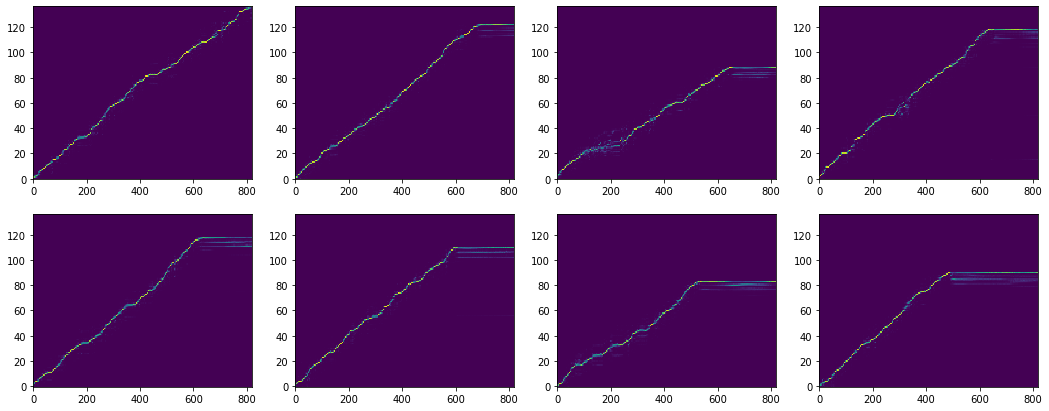

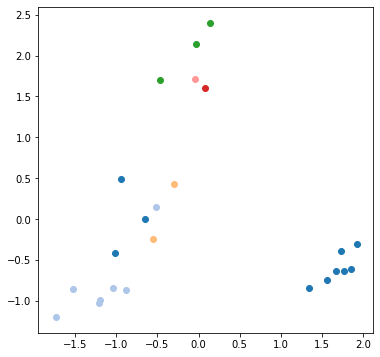

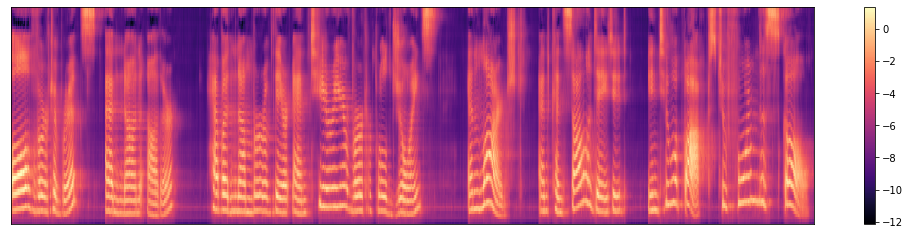

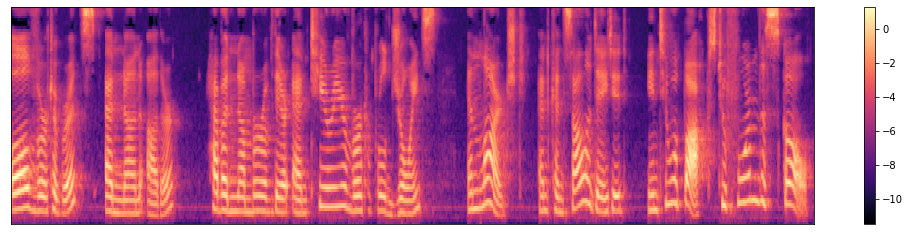

220501 0.1685483753681183 1.533207893371582
classifier loss tensor(1.1981, device='cuda:0', grad_fn=<NllLossBackward>)
220502 0.16040359437465668 2.086172580718994
classifier loss tensor(1.3538, device='cuda:0', grad_fn=<NllLossBackward>)
220503 0.14528590440750122 2.1101324558258057
classifier loss tensor(1.1428, device='cuda:0', grad_fn=<NllLossBackward>)
220504 0.15593469142913818 1.8641002178192139
classifier loss tensor(1.5045, device='cuda:0', grad_fn=<NllLossBackward>)
220505 0.1582432985305786 1.9598441123962402
classifier loss tensor(1.0701, device='cuda:0', grad_fn=<NllLossBackward>)
220506 0.16405044496059418 1.474379062652588
classifier loss tensor(1.5140, device='cuda:0', grad_fn=<NllLossBackward>)
220507 0.1483364701271057 1.6247339248657227
classifier loss tensor(1.6772, device='cuda:0', grad_fn=<NllLossBackward>)
220508 0.1672305017709732 1.9879121780395508
classifier loss tensor(1.2898, device='cuda:0', grad_fn=<NllLossBackward>)
220509 0.16458645462989807 1.7695171833

In [ ]:
import matplotlib.pyplot as plt
from IPython import display
import librosa.display
import time

first = True

while(True):
    for i, batch in enumerate(train_loader):
        t0 = time.time()
        
        model.train()
        model.zero_grad()
        batch = model.parse_batch(batch)
        
        outputs = model(batch)
        loss, losses = criterion(batch, outputs)
        
        loss.backward()
        
        grad_norm = torch.nn.utils.clip_grad_norm_(
                    model.parameters(), hparams.grad_clip_thresh)
        
        optimizer.step()
        
        t1 = time.time()
        print(step, loss.item(), t1 - t0)
        print('classifier loss', losses['classifier_loss'])
        
        if step % 10 == 0:
            logger.log('training loss', loss.item(), step)

        if step % 500 == 0 or first:
            first = False
            display.clear_output()

            _mels = batch["mel_padded"].data.cpu().numpy()
            _outputs = outputs["mel_outputs"].data.cpu().numpy()
            _alignments = outputs["alignments"].data.cpu().numpy()
            _speakers = batch["speakers"].data.cpu().numpy()
            _prosody = outputs["prosody_outputs"].data.cpu().numpy()
            
            plt.figure(figsize=[18, 7])
            for i in range(8):
                plt.subplot(2, 4, i+1)
                plt.imshow(_alignments[i].T, aspect='auto', origin='lower', interpolation='none')

            plt.show()
            
            from sklearn.decomposition import PCA
            _prosody_outputs = PCA(n_components=2).fit_transform(_prosody)
            
            from matplotlib import colors
            from matplotlib import cm
            cluster_colors = cm.get_cmap('tab20').colors
            
            plt.figure(figsize=[6, 6])
            for i in range(10):
                plt.scatter(_prosody_outputs[_speakers==i, 0], _prosody_outputs[_speakers==i, 1], color=cluster_colors[i])
            plt.show()
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(_outputs[0])
            plt.colorbar()
            plt.show()
            
            plt.figure(figsize=[18, 4])
            librosa.display.specshow(_mels[0])
            plt.colorbar()
            plt.show()

        if step % 1000 == 0:
            if not os.path.exists(save_dir):
                os.mkdir(save_dir)

            path = save_dir + '/' + 'save_' + str(step)
            torch.save({
                'step': step,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()}, path)
            print('saved', path)
            
        step += 1


In [ ]:
path = save_dir + '/' + 'save_' + str(step)
torch.save({
    'step': step,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()}, path)
print('saved', path)